In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

plt.style.use('ggplot')

import nltk

In [6]:
df = pd.read_csv('./Reviews.csv')
df = df.head(1000)
df.shape

(1000, 10)

# EDA

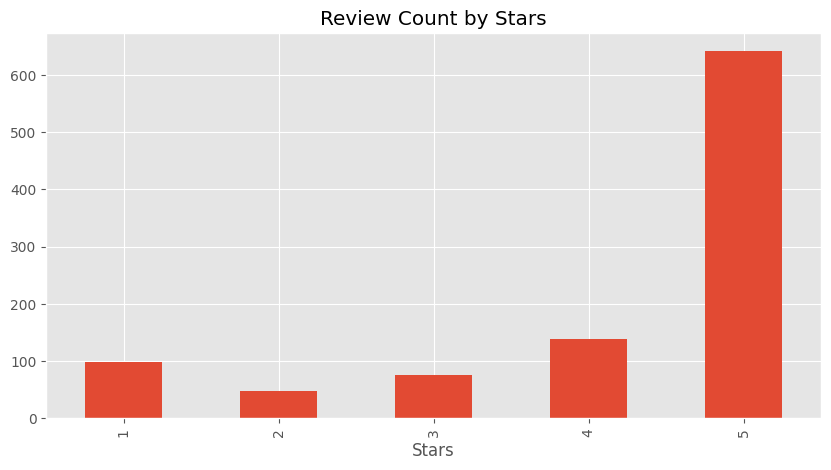

In [7]:
ax =df['Score'].value_counts().sort_index().plot(kind='bar', title='Review Count by Stars', figsize=(10, 5))
ax.set_xlabel('Stars')
plt.show()

# Roberta Pretrained Model

In [8]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL) 

In [9]:
text = df['Text'][50]
print(text)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [10]:
#   Roberta Model
encoded_text = tokenizer(text, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687465,
 'roberta_pos': 0.0029573692}

In [11]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [13]:
from tqdm.notebook import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = {**roberta_result}
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [14]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

/home/oradev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


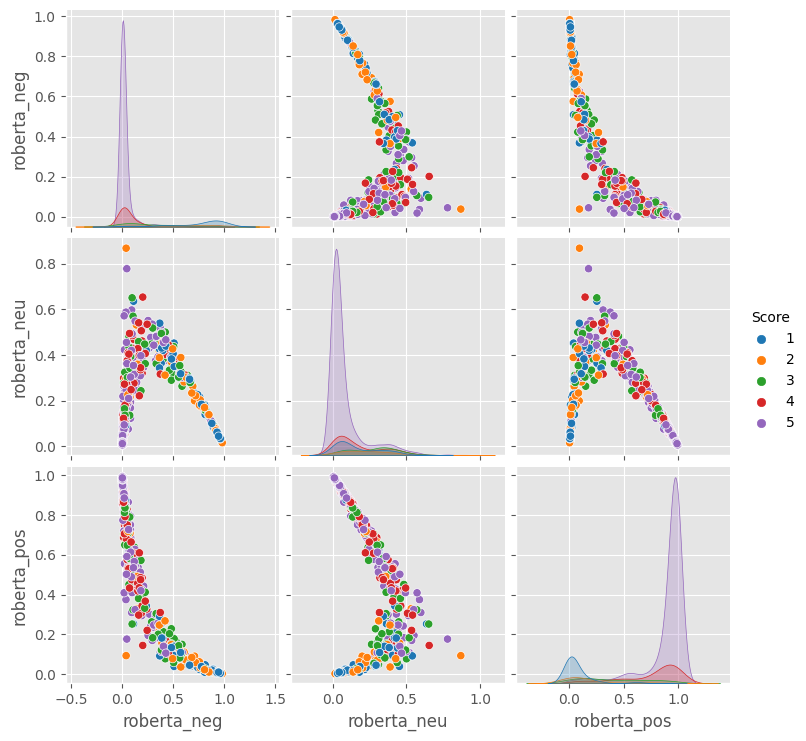

In [15]:
sns.pairplot(data=results_df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Positive 1-Star and Negative 5-Star Sentiment Reviews

In [16]:
# Positive sentiment 5-Star view

results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [ ]:
# nevative sentiment 5-Star view

